# KNN model

In [1]:
import pickle
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import gc

from load_cifar10 import load_CIFAR10

In [2]:
np.__version__
np.random.seed(2020)
random.seed(2019)

In [3]:
from sklearn.model_selection import train_test_split
from skimage import data, exposure
from skimage import feature as ft
from skimage.color import rgb2gray
from sklearn.decomposition import PCA

In [4]:
cifar_dir = "./dataset/cifar-10-batches-py/"

In [5]:
X_train, y_train, X_test, y_test = load_CIFAR10(cifar_dir)

In [6]:
# # 转化成灰度图对acc没有提升
# # 放弃
# X_train = rgb2gray(X_train)
# X_test = rgb2gray(X_test)

In [7]:
X_train.shape

(50000, 32, 32, 3)

In [8]:
# X_train, _, y_train, _ = train_test_split(
#      X_train, y_train, test_size=0.8, random_state=42)
# X_train, y_train, = X_train[:10000],y_train[:10000]

## 提取图像的HOG特征并可视化

In [9]:
image = data.astronaut()
fd, hog_image  = ft.hog(image,  # input image
              orientations=8,  # number of bins
              pixels_per_cell=(16,16), # pixel per cell
              cells_per_block=(2,2), # cells per blcok
              block_norm = 'L2', #  block norm : str {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}
              transform_sqrt = True, # power law compression (also known as gamma correction)
              feature_vector=True, # flatten the final vectors
              visualise=True) # return HOG map

c:\users\郭潇俊\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


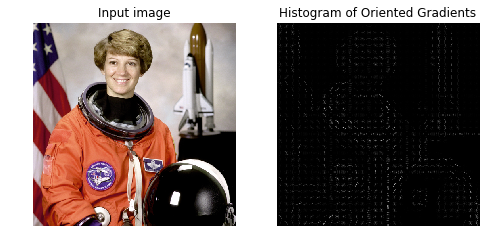

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [11]:
X_train_feature = []
for img in X_train:
    features = ft.hog(img,  # input image
                  orientations=16,  # number of bins
                  pixels_per_cell=(8,8), # pixel per cell
                  cells_per_block=(4,4), # cells per blcok
                  block_norm = 'L1-sqrt', #  block norm : str {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}
                  transform_sqrt = True, # power law compression (also known as gamma correction)
                  feature_vector=True, # flatten the final vectors
                  visualise=False) # return HOG map
    X_train_feature.append(features)
X_test_feature = []
for img in X_test:
    features = ft.hog(img,  # input image
                  orientations=16,  # number of bins
                  pixels_per_cell=[8,8], # pixel per cell
                  cells_per_block=[4,4], # cells per blcok
                  block_norm = 'L1-sqrt', #  block norm : str {‘L1’, ‘L1-sqrt’, ‘L2’, ‘L2-Hys’}
                  transform_sqrt = True, # power law compression (also known as gamma correction)
                  feature_vector=True, # flatten the final vectors
                  visualise=False) # return HOG map
    X_test_feature.append(features)

X_train_feature = np.array(X_train_feature)
X_test_feature = np.array(X_test_feature)

c:\users\郭潇俊\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [12]:
del X_train
del X_test

In [13]:
X_train_feature.shape

(50000, 256)

In [14]:
pca = PCA(128)
pca.fit(X_train_feature)

print(pca.explained_variance_ratio_)
# print(pca.explained_variance_)
print(pca.n_components_)

[0.08593558 0.0362477  0.03379183 0.02870911 0.02299594 0.02196098
 0.02106213 0.01874641 0.01694034 0.01658395 0.01551032 0.01444596
 0.01414699 0.0133584  0.01119013 0.01062918 0.01019163 0.0098884
 0.0096448  0.008712   0.00847885 0.00840717 0.00803065 0.00793411
 0.00782705 0.00757874 0.0073985  0.00706182 0.00690937 0.00668626
 0.00650031 0.00648537 0.00638082 0.00629908 0.00608292 0.00581082
 0.00569289 0.00556705 0.00538905 0.00536635 0.00531879 0.00515194
 0.00505642 0.00488535 0.00485046 0.00473771 0.0046667  0.00462028
 0.00453461 0.00441949 0.00435444 0.00431761 0.00408223 0.00402282
 0.00393249 0.0039     0.0038334  0.00370962 0.00361934 0.00357663
 0.0035206  0.00342714 0.00341131 0.00333312 0.00329593 0.00324341
 0.00317072 0.00315392 0.00310943 0.00306862 0.00303183 0.00297858
 0.00292573 0.00291015 0.00284945 0.00280401 0.00278986 0.00275728
 0.00268788 0.00265788 0.00261686 0.00256987 0.00254117 0.00253152
 0.00250574 0.00244532 0.00243229 0.00241917 0.00239111 0.00236

In [15]:
X_train_feature = pca.transform(X_train_feature)
X_test_feature = pca.transform(X_test_feature)

In [16]:
# X_train_feature = np.array(X_train)
# X_test_feature = np.array(X_test)

In [17]:
# 把图片从3000维提取288维特征
X_train_feature.shape

(50000, 128)

In [18]:
def standardization(X_train,X_test):
    """标准化输入的图片"""
    mean = np.mean(X_train,axis=0)
    std = np.std(X_train,axis=0)
    return (X_train-mean)/std, (X_test-mean)/std

In [19]:
# 提取HOG后不再需要标准化
# X_train,X_test = standardization(X_train,X_test)

In [20]:
import random
def randomArgMax(vec):
    """如果有多个最大值，则随机选一个"""
    _max = max(vec)
    selected = []
    for i in range(len(vec)):
        if vec[i] == _max:
            selected.append(i)
    return random.choice(selected)

def arg_minK(num_list,k=1):
    """返回前K个最小值的坐标"""
    arg_minK = np.argpartition(num_list, k)[:k]
    return arg_minK

In [21]:
class Classifier(object):
    def __init__(self,input_dim,n_of_classes):
        self.feature_dim = input_dim
        self.n_of_classes = n_of_classes
    def train(self):
        return 
    def predict(self):
        return
    def test(self):
        return 
    def reset_hyperparameter(self,**hyperparameters):
        for k,v in hyperparameters.items():
            if k in vars(self) and type(v) == type(vars(self)[k]):
                vars(self)[k] = v
        pass

In [22]:
class KNN(Classifier):
    def __init__(self,input_dim,n_of_classes,K=1,distance_type = "L2",weight = "uniform"):
        super().__init__(input_dim,n_of_classes)
        if distance_type not in ["L1","L2","COSINE"]:
            raise ValueError
        if weight not in ["uniform","distance"]:
            raise ValueError
        self.K = K
        self.distance_type = distance_type
        self.weight = weight
        
    def train(self,X_train,y_train):
        # 把每个样本的特征reshape成一个向量
        self.X_train = np.reshape(X_train,(X_train.shape[0],-1))
        self.y_train = y_train
        print("==> finish training process")
        
    def test(self,X_test,y_test):
        """直接调用predict进行测试"""
        n_of_test = X_test.shape[0]
        _X_test = np.reshape(X_test,(n_of_test,-1))
        results = []
        for i in range(n_of_test):
            pred = self.predict(_X_test[i])
            results.append(pred)
        print("==> ACC = %.2f %%"%(100*sum(np.array(results)==y_test)/len(y_test)))
    
    def predict(self,input_img):
        """预测单个样本"""
        _img = np.reshape(input_img,-1)
        if self.distance_type == "L1":
            dis = np.sum(np.abs((self.X_train-_img)),axis=1)
        elif self.distance_type == "L2":
            dis = np.sqrt(np.sum(np.power((self.X_train-_img),2),axis=1))
        elif self.distance_type == "COSINE":
            dis = 1-self.X_train.dot(_img)/np.sqrt(np.sum(self.X_train**2,axis=1)*np.sum(_img**2))
        else:
            raise ValueError
        sorted_arg = arg_minK(dis,k=self.K)
        if self.weight == "uniform":
            vote = [0 for i in range(self.n_of_classes)]
            for i in range(self.K):
#                 print("dist = ",(dis[sorted_arg[i]]+1e-6))
                vote[self.y_train[sorted_arg[i]]] += 1
            result = randomArgMax(vote)
        elif self.weight == "distance":
            vote = [0 for i in range(self.n_of_classes)]
            for i in range(self.K):
#                 print("dist = ",(dis[sorted_arg[i]]+1e-6))
                vote[self.y_train[sorted_arg[i]]] += 1/(dis[sorted_arg[i]]+1e-6)
            result = randomArgMax(vote)
        else:
            raise ValueError
        
        return result
        
    def cal_dist(self,X_test):
        """利用numpy的广播操作，减少循环次数,计算X_test 所有样本和X_train 所有样本的距离"""
        n_of_test = X_test.shape[0]
        n_of_train = self.X_train.shape[0]
        _X_test = np.reshape(X_test,(n_of_test,-1))
        """
        对于X_test 维度为 A*F, X_train 维度为 B*F
        
        距离矩阵dist 中， i,j 号元素表示X_test[i] 与 X_train[j]的距离
        
        则对于 L2 距离 dist[i][j] = sum(X_test[i]**2) + sum(X_train[j]**2) - 2 * X_test[i] * X_train[j].T (行向量乘以列向量)
        
        对于L1距离, 不能这么做
        """
        n_of_train = self.X_train.shape[0]
        if self.distance_type == "L1":
            dist = np.zeros((n_of_test,n_of_train))
            for i in range(n_of_test):
                _ = np.sum(np.abs(self.X_train - _X_test[i]),axis=1)
                dist[i] = _
        elif self.distance_type == "L2":
            dist = -2*_X_test.dot(self.X_train.T) + np.sum(np.square(_X_test),axis=1,keepdims=1) + np.sum(np.square(self.X_train),axis=1).T
        elif self.distance_type == "COSINE":
            dist = (1-_X_test.dot(self.X_train.T)/np.sqrt(np.sum(_X_test**2,axis=1,keepdims=True) * np.sum(self.X_train**2,axis=1).T))
        else:
            del _X_test
            raise ValueError
        del _X_test
        
        return dist
        
    def fast_test(self,X_test,y_test):
        n_of_test = X_test.shape[0]
        results = []
        
        dist = self.cal_dist(X_test)
        
        
        if self.weight == "uniform":
            for i in range(n_of_test):
                sorted_arg = arg_minK(dist[i],k=self.K)
                vote = [0 for i in range(self.n_of_classes)]
                for j in range(self.K):
                    vote[self.y_train[sorted_arg[j]]] += 1
                result = randomArgMax(vote)

                results.append(result)
        elif self.weight == "distance":
            for i in range(n_of_test):
                sorted_arg = arg_minK(dist[i],k=self.K)
                vote = [0 for i in range(self.n_of_classes)]
                for j in range(self.K):
                    vote[self.y_train[sorted_arg[j]]] += 1/(dist[i][sorted_arg[j]]+1e-6)
                result = randomArgMax(vote)

                results.append(result)
        else:
            raise ValueError
                
        print("==> ACC = %.2f %%"%(100*sum(np.array(results)==y_test)/len(y_test)))
        return sum(np.array(results)==y_test)/len(y_test)
        
    def fast_test_with_dist(self,dist,y_test):
        
        n_of_test = dist.shape[0]
        results = []
        
        if self.weight == "uniform":
            for i in range(n_of_test):
                sorted_arg = arg_minK(dist[i],k=self.K)
                vote = [0 for i in range(self.n_of_classes)]
                for j in range(self.K):
                    vote[self.y_train[sorted_arg[j]]] += 1
                result = randomArgMax(vote)

                results.append(result)
        elif self.weight == "distance":
            for i in range(n_of_test):
                sorted_arg = arg_minK(dist[i],k=self.K)
                vote = [0 for i in range(self.n_of_classes)]
                for j in range(self.K):
                    vote[self.y_train[sorted_arg[j]]] += 1/(dist[i][sorted_arg[j]]+1e-6)
                result = randomArgMax(vote)

                results.append(result)
        else:
            raise ValueError
            
            
        
        
        print("==> ACC = %.2f %%"%(100*sum(np.array(results)==y_test)/len(y_test)))
        return sum(np.array(results)==y_test)/len(y_test)
        
    def fast_predcit(self,X_test,y_test):
        """预测多个样本"""
        n_of_test = X_test.shape[0]
        results = []
        dist = self.cal_dist(X_test)
        
        for i in range(n_of_test):
            sorted_arg = arg_minK(dist[i],k=self.K)
            vote = [0 for i in range(self.n_of_classes)]
            for j in range(self.K):
                vote[self.y_train[sorted_arg[j]]] += 1
            result = randomArgMax(vote)
            
            results.append(result)
        return results

In [27]:
knn = KNN(input_dim=(32, 32, 3),n_of_classes=10,K=5)
knn.train(X_train_feature,y_train)

==> finish training process


In [29]:
dist = knn.cal_dist(X_test_feature[:n_of_test])

In [35]:
# 修改距离类型和K
knn.reset_hyperparameter(**{"distance_type":"COSINE","K":9,"weight":"distance"})

# 测试数
n_of_test = 10000

In [36]:
knn.fast_test_with_dist(dist=dist,y_test=y_test[:n_of_test]) 

==> ACC = 62.04 %


0.6204

In [34]:
acc_vs_k = []
for k in range(0,30):
    print("K = ",k+1,end='')
    knn.reset_hyperparameter(**{"K":k+1})
    acc_vs_k.append( knn.fast_test_with_dist(dist=dist,y_test=y_test[:n_of_test]) )

K =  1==> ACC = 56.17 %
K =  2==> ACC = 56.17 %
K =  3==> ACC = 58.97 %
K =  4==> ACC = 60.52 %
K =  5==> ACC = 60.69 %
K =  6==> ACC = 61.02 %
K =  7==> ACC = 61.43 %
K =  8==> ACC = 61.76 %
K =  9==> ACC = 62.04 %
K =  10==> ACC = 61.88 %
K =  11==> ACC = 61.98 %
K =  12==> ACC = 61.92 %
K =  13==> ACC = 61.84 %
K =  14==> ACC = 62.06 %
K =  15==> ACC = 61.59 %
K =  16==> ACC = 61.85 %
K =  17==> ACC = 61.89 %
K =  18==> ACC = 62.03 %
K =  19==> ACC = 61.91 %
K =  20==> ACC = 61.75 %
K =  21==> ACC = 61.77 %
K =  22==> ACC = 61.89 %
K =  23==> ACC = 62.07 %
K =  24==> ACC = 62.03 %
K =  25==> ACC = 61.81 %
K =  26==> ACC = 62.01 %
K =  27==> ACC = 62.11 %
K =  28==> ACC = 61.98 %
K =  29==> ACC = 61.99 %
K =  30==> ACC = 61.95 %


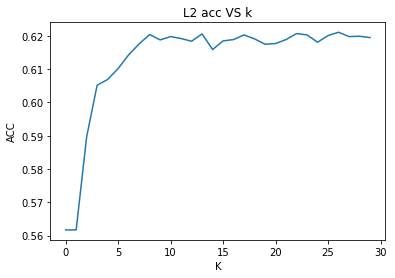

In [37]:
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

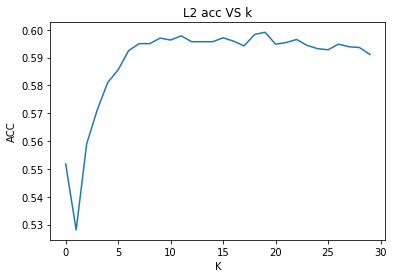

In [28]:
# hog, not-standardization,50000 train 10000 test  with pca 150, block_norm = 'L1-sqrt'
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

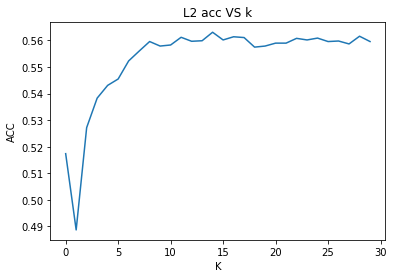

In [27]:
# hog, not-standardization,50000 train 10000 test  with pca 150, block_norm = 'L2'
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

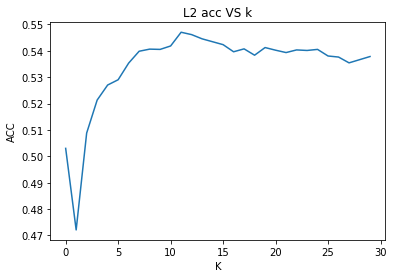

In [23]:
# hog, not-standardization,50000 train 10000 test  no pca, block_norm = 'L1'
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

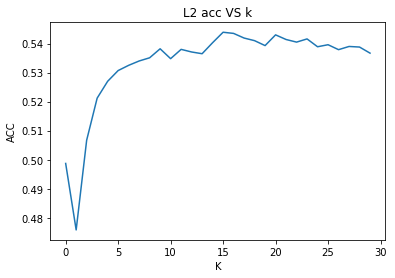

In [28]:
# hog, not-standardization,50000 train 10000 test  with pca 100, block_norm = 'L1'
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

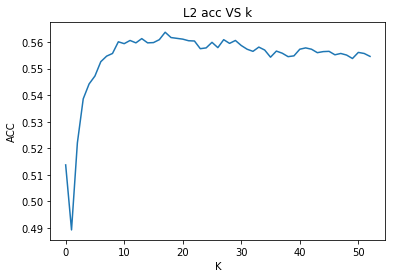

In [30]:
# hog, not-standardization,50000 train 10000 test  with pca 100, block_norm = 'L2'
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

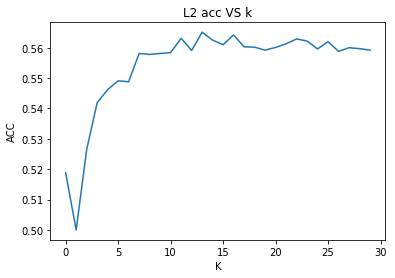

In [29]:
# hog, not-standardization,50000 train 10000 test  with pca 200, block_norm = 'L2'
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

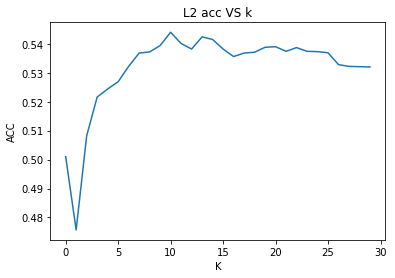

In [28]:
# hog, not-standardization,50000 train 10000 test 
plt.title("L2 acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

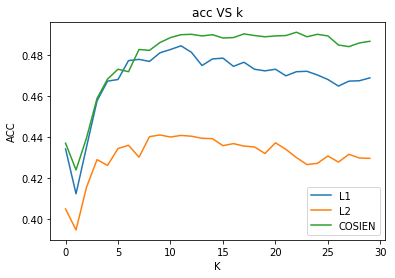

In [90]:
# 绘图程序
# hog, not-standardization,10000 train 5000 test 
plt.title("acc VS k")
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k_l1)
plt.plot(acc_vs_k_l2)
plt.plot(acc_vs_k_cosine)
plt.legend(['L1','L2','COSIEN'])#
plt.show()

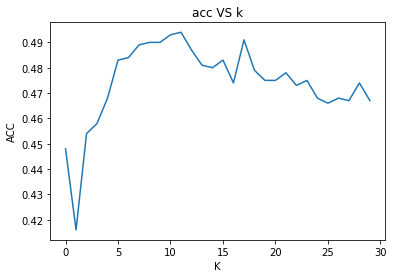

In [50]:
# L1 hog, not-standardization,10000 train 10000 test 
# acc VS k
plt.title("acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

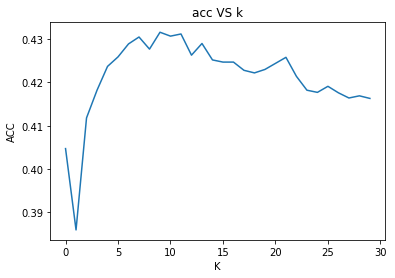

In [45]:
# L2 hog, not-standardization,10000 train 10000 test 
# acc VS k
plt.title("acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

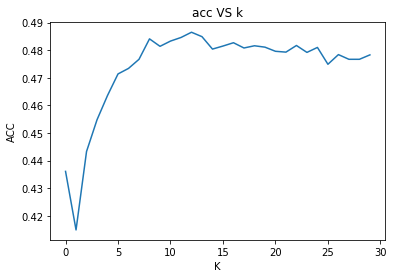

In [40]:
# COSINE hog, not-standardization,10000 train 10000 test 
# acc VS k
plt.title("acc VS k") 
plt.xlabel("K") 
plt.ylabel("ACC") 
plt.plot(acc_vs_k)
plt.show()

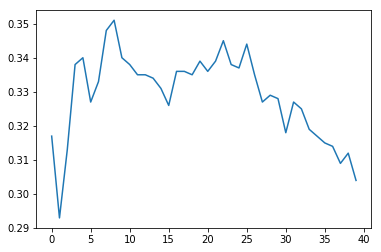

In [89]:
# l1 standardization,10000 train 1000 test 
# acc VS k
plt.plot(acc_vs_k[:40])

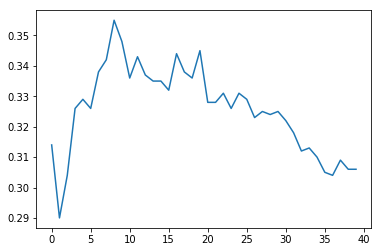

In [47]:
# l1 not-standardization,10000 train 1000 test 
# acc VS k
plt.plot(acc_vs_k[:40])

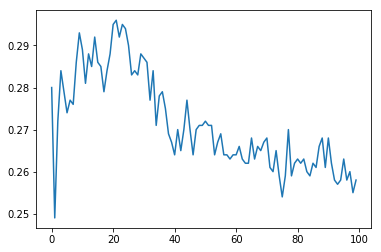

In [78]:
# l2 standardization,10000 train 10000 test 
# acc VS k
plt.plot(acc_vs_k)

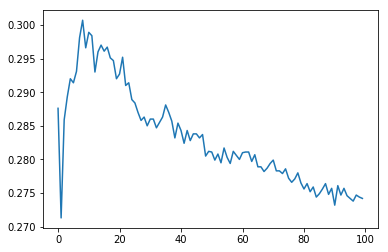

In [43]:
# l2 not-standardization,10000 train 10000 test 
# acc VS k
plt.plot(acc_vs_k)